<a href="https://colab.research.google.com/github/aa3281/smart-contract-security-analysis-study/blob/main/Externship_Webacy_Cluster_Analysis_of_Smart_Contract_Risk_Audits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Externship Webacy Cluster Analysis of Smart Contract Risk Audits by Alessandra Adina

## Data Preparation

In [ ]:
# Import necessary Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import fcluster

print("Libraries imported successfully!")


Libraries imported successfully!


In [ ]:
!gdown 15Y1WnWIhaa5CKvjNR2S8SfbX61Z1PzuK

Downloading...
From: https://drive.google.com/uc?id=15Y1WnWIhaa5CKvjNR2S8SfbX61Z1PzuK
To: /content/compiled_risk_data.xlsx
100% 311k/311k [00:00<00:00, 21.3MB/s]


In [ ]:
# Loading the dataset

df = pd.read_excel('compiled_risk_data.xlsx')

# Display the first five rows of the dataframe
df.head()

,project_name,Smart contract address,Blog post link,Audit website,Chain,Is_closed_source,hidden_owner,anti_whale_modifiable,Is_anti_whale,Is_honeypot,...,centralized_risk_high,centralized_risk_low,event_setter,external_dependencies,immutable_states,reentrancy_without_eth_transfer,incorrect_inheritance_order,shadowing_local,events_maths,Summary/rationale of risk tags marked true
0,Data Analytics,384571416209d08623c6ace9422613fc8970475d,https://chainsecurity.com/security-audit/circl...,https://chainsecurity.com,Ethereum,False,False,False,False,False,...,False,False,True,True,True,True,False,False,False,Bad Contract: Assigned for flaws that indicate...
1,Data Analytics,0xAb5801a7D398351b8bE11C439e05C5B3259ae9B,https://stackoverflow.com/questions/75030483/w...,https://studygroup.moralis.io/t/compilation-er...,Ethereum,False,False,True,True,False,...,False,True,False,True,False,False,True,False,True,Summary/rationale of risk tags marked true: Th...
2,Data Analytics,0x4B20993Bc481177ec7E8f571ceCaE8A9e22C02db,https://stackoverflow.com/questions/71115106/s...,https://ethereum.stackexchange.com/questions/1...,Ethereum,True,False,False,True,False,...,False,True,False,True,False,False,False,True,True,NaN
3,Data Analytics,0x78731D3Ca6b7E34aC0F824c42a7cC18A495cabaB,https://stackoverflow.com/questions/75030483/w...,https://studygroup.moralis.io/t/compilation-er...,Ethereum,True,False,False,False,True,...,False,True,False,False,True,True,False,False,True,NaN
4,Data Analytics,0x617F2E2fD72FD9D5503197092aC168c91465E7f2,https://stackoverflow.com/questions/69466137/h...,https://ethereum.stackexchange.com/questions/1...,Ethereum,True,False,True,False,True,...,False,False,True,True,False,True,False,False,True,The smart contract is marked with risks such a...


As with our cluster and frequency analysis, we can drop the first 5 columns of our data set, and set the first row as index, to make our analysis easier.

In [ ]:
# Drop the first 5 columns
df = df.iloc[:, 5:]

# Drop the summary column (last column)
df = df.iloc[:, :-1]

# Set the first row as index
df = df.set_index(df.columns[0])

# Reset columns index
df.reset_index(inplace=True)

# Display the first five rows of the dataframe
df.head()

,Is_closed_source,hidden_owner,anti_whale_modifiable,Is_anti_whale,Is_honeypot,buy_tax,sell_tax,slippage_modifiable,Is_blacklisted,can_take_back_ownership,...,centralized_risk_medium,centralized_risk_high,centralized_risk_low,event_setter,external_dependencies,immutable_states,reentrancy_without_eth_transfer,incorrect_inheritance_order,shadowing_local,events_maths
0,False,False,False,False,False,False,False,False,False,False,...,True,False,False,True,True,True,True,False,False,False
1,False,False,True,True,False,True,False,False,False,False,...,False,False,True,False,True,False,False,True,False,True
2,True,False,False,True,False,False,False,True,False,True,...,False,False,True,False,True,False,False,False,True,True
3,True,False,False,False,True,False,True,False,False,False,...,True,False,True,False,False,True,True,False,False,True
4,True,False,True,False,True,False,False,False,True,False,...,False,False,False,True,True,False,True,False,False,True


## Feature Selection

For clustering smart contracts, we select features that represent different risk tags effectively.

For this analysis, we have included the following risks as features:

1. **Exploitation (468 occurrences):** As the most frequent risk, exploitation indicates vulnerabilities that are highly exploitable by malicious actors. Understanding and mitigating these risks are paramount for protecting contract assets and maintaining user trust.

2. **Bad Contract (373 occurrences):** Contracts categorised as 'bad' due to fundamental flaws or vulnerabilities pose substantial risks to operational integrity and financial security. Addressing these vulnerabilities is critical for ensuring contract reliability and user confidence.

3. **Reentrancy without ETH Transfer (199 occurrences):** Vulnerabilities related to reentrancy attacks without involving ETH transfer highlight specific weaknesses in contract logic and transaction handling. This is also one of the most often talked about risks for contracts, for people with domain knowledge of the topic.

4. **Hidden Owner (164 occurrences):** Contracts with hidden owners pose significant risks due to lack of transparency and accountability. Obscured identities can lead to misuse of control over contract functionalities, making it crucial to assess these risks thoroughly.

5. **Can Take Back Ownership (194 occurrences):** This risk involves contracts where the owner retains the ability to reclaim ownership or control. Such capabilities introduce uncertainties and potential for unexpected changes in contract behaviour, highlighting a critical area for security evaluation.

6. **Owner Change Balance (222 occurrences):** Risks related to the owner's ability to modify contract balances are fundamental for financial security and integrity. These risks can impact user trust and operational stability, necessitating careful consideration in contract design and implementation.

7. **Buy Tax (128 occurrences):** Taxes applied to purchases within contracts introduce financial considerations and transparency requirements. Managing buy taxes effectively is crucial for ensuring fair transactions and compliance with regulatory standards.

8. **Sell Tax (126 occurrences):** Similar to buy taxes, taxes applied to sales within contracts impact transactional fairness and financial outcomes. Monitoring and managing sell taxes help maintain equitable practices and user trust.

9. **Slippage Modifiable (149 occurrences):** Risks associated with adjustable slippage rates affect transaction pricing and execution within contracts. Understanding and controlling slippage modifiability is essential for preventing financial losses and ensuring predictable transaction outcomes.

10. **External Dependencies (316 occurrences):** Risks related to reliance on external contracts or data sources expand the attack surface and introduce dependencies beyond direct control. Managing external dependencies is critical for maintaining contract integrity and operational security.

11. **Centralized Risk (Medium, High, Low):** Categorising risks by levels of centralisation (medium, high, low) helps assess varying degrees of security concerns. Understanding these risks informs decisions on decentralisation strategies and security measures to mitigate associated vulnerabilities.

12. **Immutable States (154 occurrences):** Contracts with states meant to be immutable but vulnerable to modification pose integrity risks. Addressing vulnerabilities in immutable states is essential for preserving data integrity and preventing unauthorized changes.

13. **Event Setter (149 occurrences):** Risks associated with setting or managing events within contracts affect contract behaviour and operational outcomes. Managing event setters helps ensure predictable contract execution and prevents unintended consequences.

14. **Selfdestruct (116 occurrences):** Risks related to the self-destruct function within contracts introduce considerations for contract lifespan and asset protection. Managing self-destruct risks is crucial for preventing premature contract termination and asset loss.

In [ ]:
data_new = df.copy()

# Select the relevant features
feature_1 = 'exploitation'
feature_2 = 'bad_contract'
feature_3 = 'reentrancy_without_eth_transfer'
feature_4 = 'hidden_owner'
feature_5 = 'can_take_back_ownership'
feature_6 = 'owner_change_balance'
feature_7 = 'buy_tax'
feature_8 = 'sell_tax'
feature_9 = 'slippage_modifiable'
feature_10 = 'external_dependencies'
feature_11 = 'centralized_risk_medium'
feature_12 = 'centralized_risk_high'
feature_13 = 'centralized_risk_low'
feature_14 = 'immutable_states'
feature_15 = 'event_setter'
feature_16 = 'selfdestruct'

selected_features = data_new[[feature_1, feature_2, feature_3, feature_4, feature_5, feature_6, feature_7, feature_8,
  feature_9, feature_10, feature_11, feature_12, feature_13, feature_14, feature_15, feature_16]].replace({True:1, False:0})
print("Features selected for clustering:")

print(selected_features.head())


Features selected for clustering:
   exploitation  bad_contract  reentrancy_without_eth_transfer  hidden_owner  \
0             1             1                                1             0   
1             0             1                                0             0   
2             1             0                                0             0   
3             1             0                                1             0   
4             1             0                                1             0   

   can_take_back_ownership  owner_change_balance  buy_tax  sell_tax  \
0                        0                     0        0         0   
1                        0                     1        1         0   
2                        1                     1        0         0   
3                        0                     0        0         1   
4                        0                     1        0         0   

   slippage_modifiable  external_dependencies  centralized

## Applying Clustering

Hierarchical clustering provides a unique insight into how clusters are formed over different scales, which can be crucial for understanding complex relationships in data. Using both dendrograms and heatmaps allows us to visualize and quantify how smart contracts group together based on shared security vulnerabilities.

1. Dendrogram Analysis:
  1. Action: Study the dendrogram to identify significant merges and the height at which these merges occur. Analyze the cluster profiles by examining the most common risk tags or the prevalence of True values in each formed cluster.
  2. Example: Look at the point where a large jump in the dendrogram's merge height occurs—this might signify a key split between different types of risk profiles.
2. Heatmap Analysis:
  1. Action: Use a heatmap to visualize the average values or the mode of each risk tag within clusters. This visualization helps in understanding the common characteristics of contracts within each cluster.


### Hierarchical Clustering with Jaccard Distance

We will apply hierarchical clustering to our dataset using Jaccard distance, as this method is particularly effective for datasets with binary attributes, as it measures the dissimilarity between sample sets.

#### Compute Jaccard Distance
Compute the pairwise Jaccard distance between observations. Jaccard distance is a measure of how dissimilar two sets are, ranging from 0 (identical) to 1 (no common elements).

In [ ]:
from scipy.spatial.distance import pdist, squareform

# Assuming 'selected_features' is your DataFrame with binary data
distance_matrix = pdist(selected_features, 'jaccard')
distance_square_matrix = squareform(distance_matrix)  # Convert to square matrix

#### Perform Hierarchical Clustering
Using the complete linkage method, we perform hierarchical clustering. Complete linkage considers the maximum distance between observations in two clusters.

In [ ]:
import scipy.cluster.hierarchy as sch

# Create linkage matrix
linkage_matrix = sch.linkage(distance_matrix, method='ward')

linkage_matrix

array([[4.66000000e+02, 5.23000000e+02, 0.00000000e+00, 2.00000000e+00],
       [5.97000000e+02, 1.09300000e+03, 0.00000000e+00, 3.00000000e+00],
       [1.00100000e+03, 1.09400000e+03, 0.00000000e+00, 4.00000000e+00],
       ...,
       [2.17600000e+03, 2.18100000e+03, 6.03655625e+00, 7.01000000e+02],
       [2.17900000e+03, 2.18200000e+03, 7.40316270e+00, 8.52000000e+02],
       [1.75800000e+03, 2.18300000e+03, 1.55191705e+01, 1.09300000e+03]])

### Plot the Dendogram

Visualize the clustering as a dendrogram, which will help us understand the data's hierarchical structure.

The dendrogram shows how each cluster is linked, with the y-axis representing the distance (dissimilarity) at which clusters are merged. The height of the merge point indicates the similarity between clusters: lower heights suggest greater similarity.

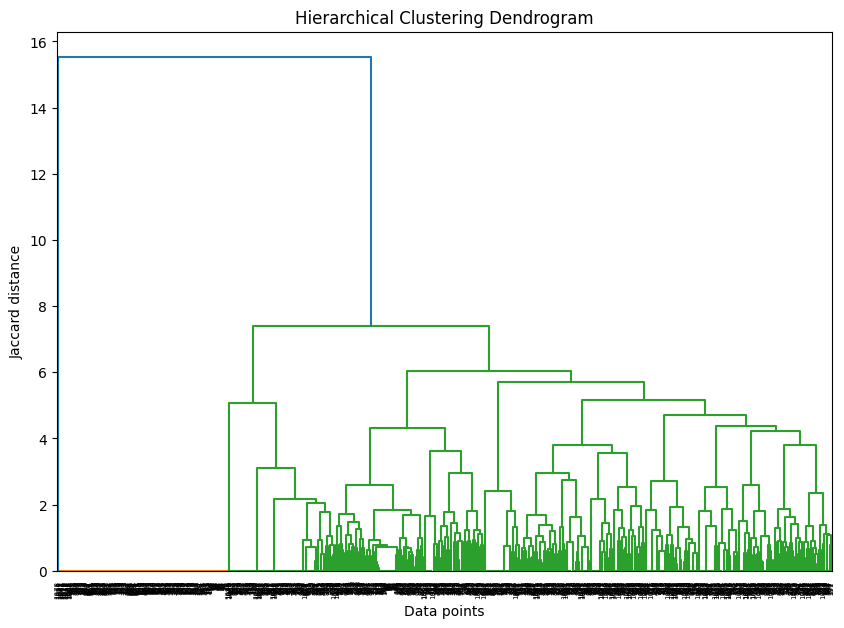

In [ ]:
# Plot the dendrogram
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
dendrogram = sch.dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data points')
plt.ylabel('Jaccard distance')
plt.show()


It can also be easier to visualise the dendrogram by making it circular.

In [ ]:
!git clone https://github.com/koonimaru/radialtree.git
!pip install radialtree/.

Cloning into 'radialtree'...
remote: Enumerating objects: 133, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 133 (delta 35), reused 29 (delta 23), pack-reused 77
Receiving objects: 100% (133/133), 1.08 MiB | 4.38 MiB/s, done.
Resolving deltas: 100% (65/65), done.
Processing ./radialtree
  Preparing metadata (setup.py) ... done
  Created wheel for radialtree: filename=radialtree-0.1.0-py3-none-any.whl size=19055 sha256=9207a19909b8a7e5c679f10b9af738f0bfc6c82a107670cd5e1bb7c5b19736c0
  Stored in directory: /tmp/pip-ephem-wheel-cache-2ynee8_s/wheels/e2/b3/9f/24ac1dfd76eee98873115156aecf588be5d8d5a2826b5ad681
Successfully built radialtree


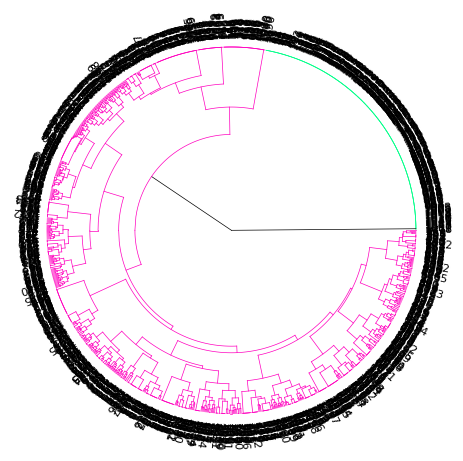

In [ ]:
import scipy.cluster.hierarchy as sch
import numpy as np
import radialtree as rt

# Configure logging to suppress or handle warnings
import logging
logging.basicConfig()
logger = logging.getLogger()
logger.setLevel(logging.ERROR)  # Set logging level to ERROR to suppress warnings


# Compute and plot the dendrogram.
Z2 = sch.dendrogram(linkage_matrix, no_plot=True)

# Plot a radial dendrogram
rt.plot(Z2)


### Visualising Clusters

We use the `fcluster` function in hierarchical clustering to transform the hierarchical clustering results into flat clusters, which are easier to interpret and analyse.  

While the dendrogram provides a detailed and comprehensive view of the data's clustering structure, it is often too complex for practical use, especially with large datasets.

The `fcluster` function simplifies this by cutting the dendrogram at a specific level, defined by a distance threshold or the desired number of clusters, to produce discrete, non-overlapping clusters. This allows us to easily assign each data point to a specific cluster and facilitates subsequent analysis and interpretation of the clustering results.

#### Determining a `t` value for `fcluster` using the elbow method

Finding a good `t` value for the `fcluster` function is crucial because it directly impacts the quality and interpretability of the clustering results.

The `t` value determines the threshold at which the dendrogram is cut, thereby defining the flat clusters.

If the `t` value is too low, it may result in too many small clusters, capturing noise rather than significant patterns.

Conversely, if the `t` value is too high, it may merge distinct groups into a few large clusters, obscuring important differences.

Therefore, choosing the right `t` value involves balancing the granularity and cohesion of clusters to achieve a robust and insightful clustering solution that can drive effective data analysis and decision-making.

The elbow method is an effective approach for determining the optimal `t` value for the `fcluster` function because it helps identify a point where adding more clusters provides diminishing returns in terms of explaining the variance in the data.







In [ ]:
# Import fcluster
from scipy.cluster.hierarchy import fcluster

In [ ]:
! pip install kneed # To install only knee-detection algorithm
! pip install kneed[plot] # To also install plotting functions for quick visualizations

In [ ]:
from kneed import KneeLocator

Using the kneedle algorithm, the knee (or elbow) point is calculated simply by instantiating the `KneeLocator` class with `x`, `y` and the appropriate curve and direction.

Here, kneedle.knee and/or kneedle.elbow store the point of maximum curvature.

In [ ]:
# Calculate the distances at each step in the dendrogram
distances = [linkage_matrix[i][2] for i in range(len(linkage_matrix))]

# Determine the optimal number of clusters using KneeLocator
x = range(1, len(distances) + 1)
y = distances[::-1]

kneedle = KneeLocator(x, y, S=1.0, curve="convex", direction="decreasing")

# The knee point returned is a value along the x axis. The y value at the knee can be identified:
print('The knee point point has a y value of', round(kneedle.knee_y, 3), 'and an x value of', round(kneedle.knee, 3))


The knee point point has a y value of 1.86 and an x value of 31


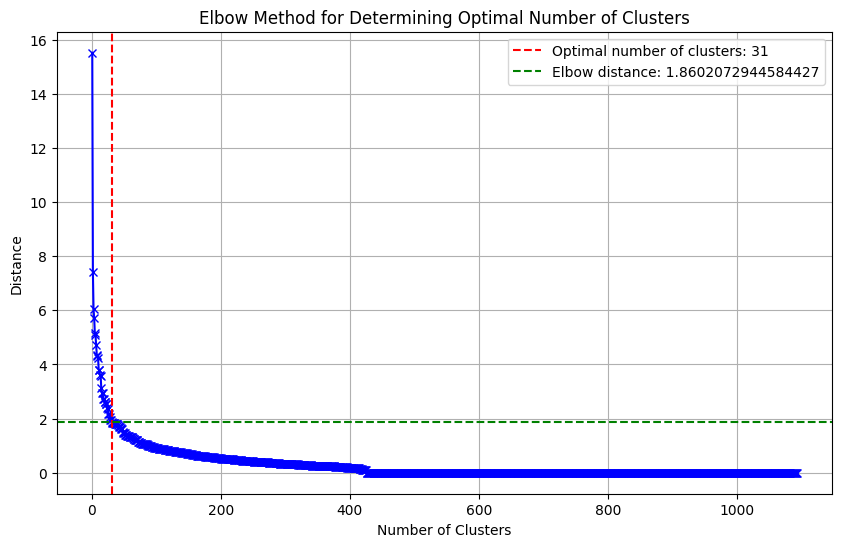

Optimal number of clusters: 31
Elbow distance value: 1.8602072944584427


In [ ]:
kn = KneeLocator(x, y, curve='convex', direction='decreasing')
optimal_clusters = kn.knee
optimal_distance = y[optimal_clusters - 1]  # Get the y-value for the optimal number of clusters

# Create the elbow graph
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'bx-')
plt.axvline(x=optimal_clusters, color='red', linestyle='--', label=f'Optimal number of clusters: {optimal_clusters}')
plt.axhline(y=optimal_distance, color='green', linestyle='--', label=f'Elbow distance: {optimal_distance}')
plt.xlabel('Number of Clusters')
plt.ylabel('Distance')
plt.title('Elbow Method for Determining Optimal Number of Clusters')
plt.legend()
plt.grid(True)
plt.show()

print(f"Optimal number of clusters: {optimal_clusters}")
print(f"Elbow distance value: {optimal_distance}")

#### Using `fcluster` with our chosen `t` value

In [ ]:
# Example: Set maximum distance at 1.86 for cluster formation
cluster_labels = fcluster(linkage_matrix, t=1.86, criterion='distance')

# Add cluster labels back to your original DataFrame
data_new['cluster'] = cluster_labels

# Summary statistics for each cluster
cluster_summary = data_new[[
    feature_1,
    feature_2,
    feature_3,
    feature_4,
    feature_5,
    feature_6,
    feature_7,
    feature_8,
    feature_9,
    feature_10,
    feature_11,
    feature_12,
    feature_13,
    feature_14,
    feature_15,
    feature_16,
    'cluster']].groupby('cluster').agg(['mean', 'std', 'median', 'count'])

cluster_summary


exploitation                        bad_contract                   \
                mean       std median count         mean       std median   
cluster                                                                     
1           0.000000  0.000000    0.0   241     0.000000  0.000000    0.0   
2           1.000000  0.000000    1.0    40     0.000000  0.000000    0.0   
3           0.000000  0.000000    0.0    24     1.000000  0.000000    1.0   
4           1.000000  0.000000    1.0    41     1.000000  0.000000    1.0   
5           0.809524  0.402374    1.0    21     1.000000  0.000000    1.0   
6           0.760000  0.435890    1.0    25     1.000000  0.000000    1.0   
7           0.325581  0.474137    0.0    43     0.604651  0.494712    1.0   
8           0.927711  0.260540    1.0    83     0.807229  0.396873    1.0   
9           0.000000  0.000000    0.0    19     0.157895  0.374634    0.0   
10          0.055556  0.232311    0.0    36     0.027778  0.166667    0.0   
11          0.172414  0.384426    0.0    29     0.206897  0.412251    0.0   
12          0.000000  0.000000    0.0    27     0.000000  0.000000    0.0   
13          0.666667  0.481543    1.0    24     0.083333  0.282330    0.0   
14          1.000000  0.000000    1.0    53     0.811321  0.394998    1.0   
15          0.500000  0.522233    0.5    12     0.500000  0.522233    0.5   
16          0.909091  0.291937    1.0    33     0.575758  0.501890    1.0   
17          0.000000  0.000000    0.0    14     0.000000  0.000000    0.0   
18          0.210526  0.418854    0.0    19     0.263158  0.452414    0.0   
19          0.350000  0.489360    0.0    20     0.000000  0.000000    0.0   
20          0.000000  0.000000    0.0    13     0.000000  0.000000    0.0   
21          0.000000  0.000000    0.0    12     0.000000  0.000000    0.0   
22          0.551724  0.506120    1.0    29     0.413793  0.501230    0.0   
23          1.000000  0.000000    1.0    13     0.615385  0.506370    1.0   
24          0.909091  0.291937    1.0    33     0.545455  0.505650    1.0   
25          0.571429  0.503953    1.0    28     0.000000  0.000000    0.0   
26          0.000000  0.000000    0.0    14     0.000000  0.000000    0.0   
27          0.466667  0.516398    0.0    15     0.200000  0.414039    0.0   
28          0.117647  0.332106    0.0    17     0.000000  0.000000    0.0   
29          0.818182  0.391675    1.0    33     0.606061  0.496198    1.0   
30          0.119048  0.327770    0.0    42     0.095238  0.297102    0.0   
31          0.761905  0.436436    1.0    21     0.904762  0.300793    1.0   
32          0.263158  0.452414    0.0    19     0.000000  0.000000    0.0   

              reentrancy_without_eth_transfer            ... immutable_states  \
        count                            mean       std  ...           median   
cluster                                                  ...                    
1         241                        0.000000  0.000000  ...              0.0   
2          40                        0.000000  0.000000  ...              0.0   
3          24                        0.000000  0.000000  ...              0.0   
4          41                        0.000000  0.000000  ...              0.0   
5          21                        0.000000  0.000000  ...              0.0   
6          25                        0.040000  0.200000  ...              0.0   
7          43                        0.558140  0.502486  ...              0.0   
8          83                        0.759036  0.430268  ...              1.0   
9          19                        0.000000  0.000000  ...              0.0   
10         36                        0.000000  0.000000  ...              0.0   
11         29                        0.103448  0.309934  ...              0.0   
12         27                        0.000000  0.000000  ...              0.0   
13         24                        0.250000  0.442326  ...              0.0   
14         53   

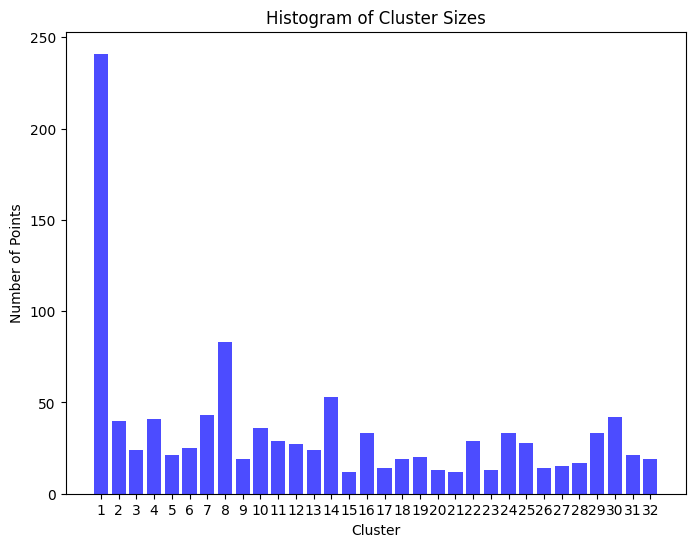

In [ ]:
# Plot histogram of cluster labels to see distribution of cluster sizes
plt.figure(figsize=(8, 6))
plt.hist(cluster_labels, bins=np.arange(1, np.max(cluster_labels)+2)-0.5, rwidth=0.8, color='blue', alpha=0.7)
plt.title('Histogram of Cluster Sizes')
plt.xlabel('Cluster')
plt.ylabel('Number of Points')
plt.xticks(np.arange(1, np.max(cluster_labels)+1))
plt.show()

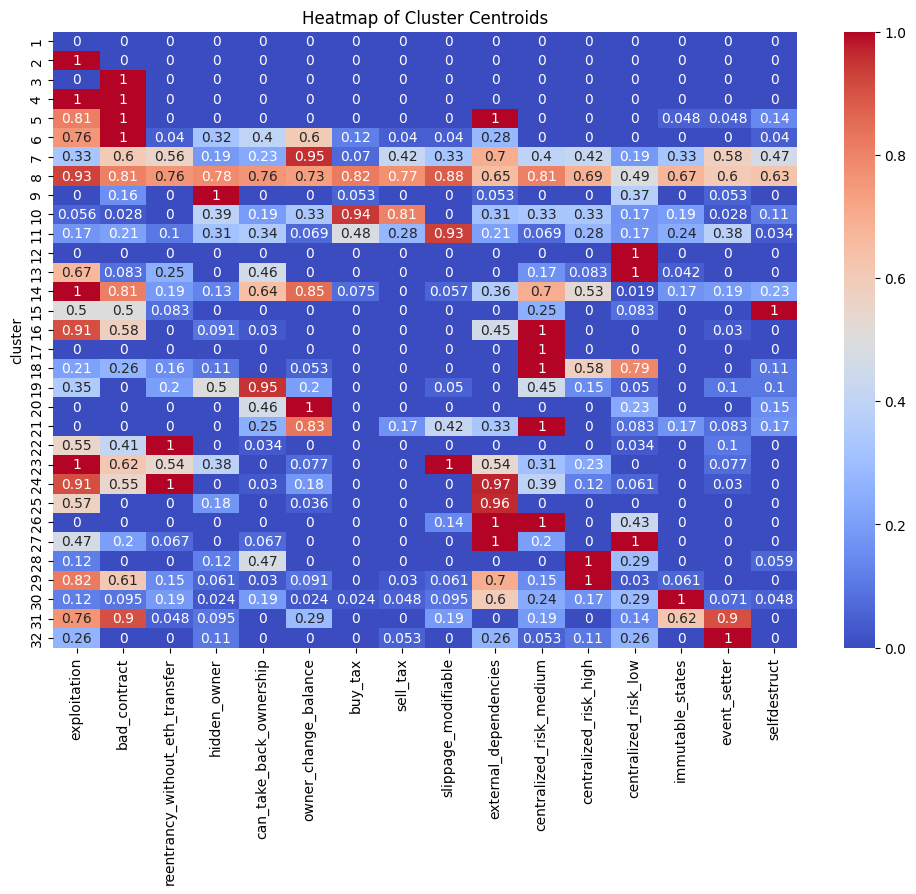

In [ ]:
# Calculate the mean for each cluster and feature
cluster_centers = data_new[[
    feature_1,
    feature_2,
    feature_3,
    feature_4,
    feature_5,
    feature_6,
    feature_7,
    feature_8,
    feature_9,
    feature_10,
    feature_11,
    feature_12,
    feature_13,
    feature_14,
    feature_15,
    feature_16,
    'cluster']].groupby('cluster').mean()

plt.figure(figsize=(12, 8))
sns.heatmap(cluster_centers, annot=True, cmap='coolwarm')
plt.title('Heatmap of Cluster Centroids')
plt.show()


## Results Overview

### Dendogram Analysis

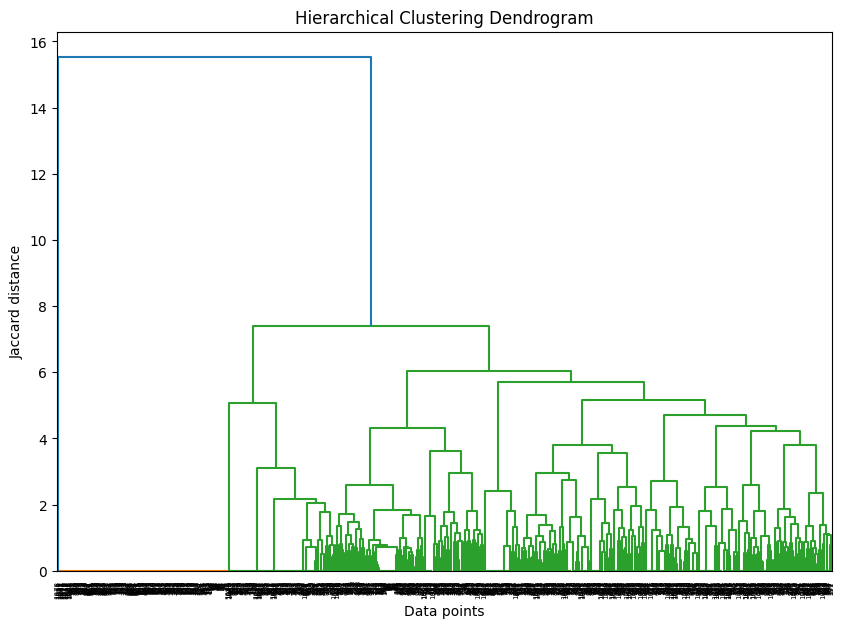

This is the dendogram that we received from our clustering. Here:
- Vertical Lines represent individual clusters or data points being linked together. The height of the line where two clusters join indicates the Jaccard distance between those clusters.
- Horizontal Lines serve as connectors and do not represent distance.

The number of clusters is not immediately clear from looking at the dendogram. Some more observations from the dendogram:

1. Large Blue Vertical Line:
  - Height: Extends up to a Jaccard distance of approximately 15.5 which is significant, suggesting a substantial dissimilarity.
  - Implication: This large distance before any linkage suggests that the cluster formed at this point significantly differs from the other data points or clusters below this level.
2. Green Cluster Groupings:
  - Sub-clusters: The green lines at the bottom of the dendrogram indicate several small clusters and sub-clusters merging at lower distances (between 0 and 2).
  - Close Proximity: These shorter green lines suggest that these data points or sub-clusters are more similar to each other, as they merge at shorter Jaccard distances.
3. Optimal Number of Clusters
  - Cut-Off Point: Given the significant jump in distance represented by the tall blue line, a practical cut-off point for determining the number of clusters might be just below this height, which would suggest considering everything below it as separate clusters.
  - This cutoff point was determined using an elbow graph

### Heatmap Analysis

The heatmap shows us the average values of each risk tag for each cluster layer.

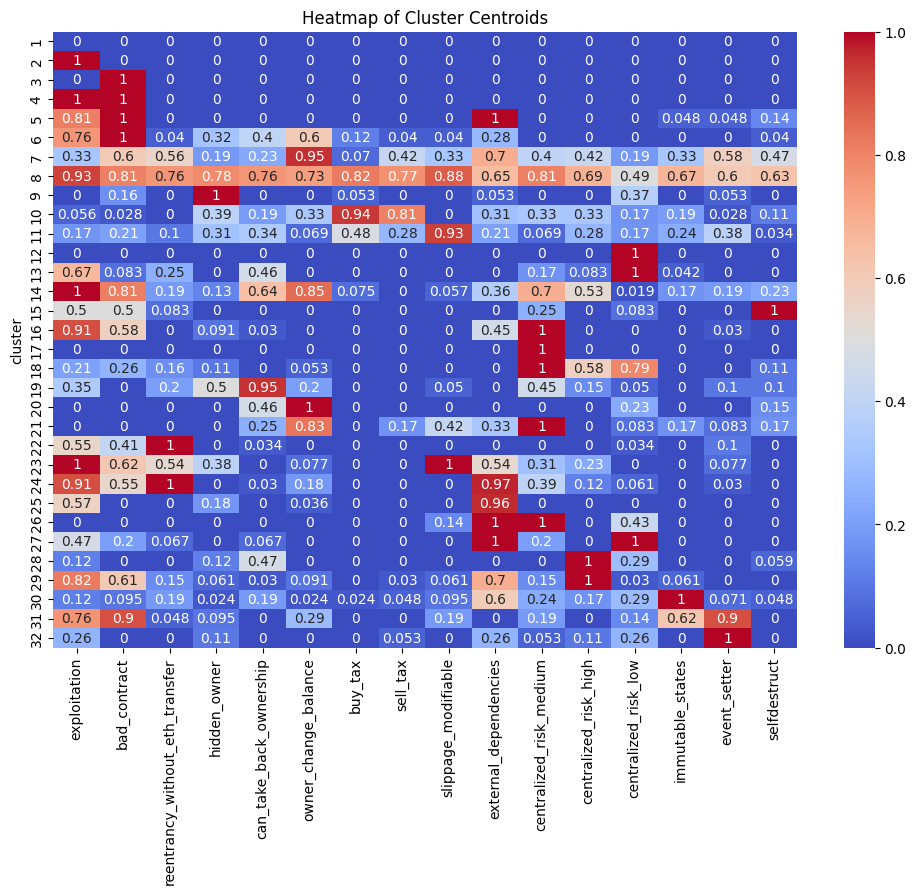


Here we observe that:
While the number of optimal clusters identified is similar to the overall number of problems, this does not appear to be how the results are clustered, with some issues being always present in multiple clusters for example.

* **Cluster 1:** All features are 0. This suggests that this cluster groups the smart contracts (or other entities) that do not have the risk factors being measured. These might be considered the 'safest' or least problematic contracts in terms of the specific risks tracked.
* **Cluster 2:** This cluster is exclusively affected by exploitation issues, with all 40 instances reporting exploitation.
* **Cluster 3:** This cluster is characterised by instances of bad contracts, with all 24 instances reporting this issue.
* **Cluster 4:** This cluster is affected by both exploitation and bad contracts, with all 41 instances reporting these issues.
* **Cluster 5:** This cluster shows a high frequency of exploitation and bad contracts, with 80.95% of instances reporting exploitation.
* **Cluster 6:**  This cluster has a high occurrence of exploitation, hidden owner, and owner change balance. There are lower occurences of other risk issues.
* **Cluster 7:** This cluster seems to contain contracts which face multiple problems, particlarly owner change balances.
* **Cluster 8:** This cluster is similar to Cluster 7, but with entries that each are afflicted by even more problems.
* **Cluster 9:** Every entry in this cluster faces issues with hidden ownership, with some also showing low centralized risk and a smattering also being recorded as facing other issues.
* **Cluster 10:** This cluster seems to concentrate items which face both buy and sell tax issues, although some face just one or the other. That there is a high number of items facing both, suggests they are tightly related issues. This is also the case for entries in Cluster 8.
* **Cluster 11:** This cluster is dominated by items which have issues with slippage modifiable, which also face a variety of otehr issues.
* **Cluster 12:** These items have centralized low risk, but no other identified issues.
* **Cluster 13:** Like Cluster 12 this cluster includes items facing centralized low risk issues, but that also face other issues such as exploitation and can take back ownership.
* **Cluster 14:** All items here face exploitation issues, they seem to be those that also face other issues (distinguishing it from cluster 2) with most facing bad contract and owner change balance issues, among others.
* **Cluster 15:** All items in this cluster face selfdestruct issues, with half facing exploitation and half (not necessarily exclusive halved) facing bad contract issues. A small number also face other issues.
* **Cluster 16:** These are items that all face centralized medium risk, and most also face eploitation issues and over half bad contract issues.
* **Cluster 17:** This is items with centralized medium risk but no other identified issues
* **Cluster 18:** This is another cluster of items facing centralized medium risk, and seems to be those which also facae centralized low or high risk
* **Cluster 19:** This is mostly items with can take back ownership issues, which are also affected by other issues. It is he only cluster with a majority of entries facing can take back ownership issues
* **Cluster 20:** These are all items facing owner change balance issues, similar to cluster 7, although items in this cluster face fewer other issues than those in cluster 7
* **Cluster 21:** This is another cluster made up of items with centralized medium risk, but is mostly entries that also face owner change balance issues
* **Cluster 22:** All items with reentrancy without eth transfer issues, half have exploitation issues and almost half have bad contrac tissues, but few face other issues
* **Cluster 23:** All these items have exploitation and slippage modifiable issues, many also face a variety of other issues
* **Cluster 24:** All tiems with reentry without eth transfer issues and almost all also having exploitation and external dependencies issues, making this a cluster defined by the intersection of those 3 issues
* **Cluster 25:** A cluster with almost all items facing external dependencies issues, over half also face exploitation issues, but unlike cluster 24 none face reetnry without eth transfer issues
* **Cluster 26:** All items which face both external dependencies issues and centralized risk medium issues, with this combination separating it from clusters 17 and 18 and 24 and 25 and 27, and ahving items which don't have exploitation issues separating it from cluster 16
* **Cluster 27:** All items face external dependencies issues and have centralized risk low issues.
* **Cluster 28:** All items with centralized high risk issues, and a small number facing other issues such as can take back ownership
* **Cluster 29:** All items with centralized high risk issues, but almost none with can take back ownership (Cluster 28) and most also facing exploitation issues
* **Cluster 30:** All entries face immutable stress issues, and perhaps may be those with this and just one other issue
* **Cluster 31:** Mostly items facing both bad contract and event setter issues, with many also facing exploitation and immutable state issues.
* **Cluster 32:** Like cluster 31 containing items with event setter issues, but has none with bad contract issues

### Drawing Insights

1. Risk Profiling:
  - Overall there are a mix of clusters. Some are defined by focus on a single issue, or the intersection of multiple issues. Some seem to be also defined by tiems facing one or a few issues, while other clusters seem to contain items which face multiple issues.

2. Targeted Actions or Further Analysis:
  - We could take a closer look into risk tags that have high colleration, such as buy tax and sell tax. These may not be distinct issues at all, but functions of similar root causes.
  - Examination should also take place into the clusters whose entries show a high propensity for multiple risk factors. Identifying the causes underlying inclusion in these clusters may help better preempt the likelihood of issues occurring.  

3. Policy or Monitoring Adjustments:
  - Enhancements in risk detection tools might be necessary to better capture the nuanced risk profiles observed in different clusters.